 ### <center>Sanity Checks!</center> 

In [23]:
import math
import xarray as xr
import numpy as np
import calendar
import pandas as pd
import datetime
import os
import cftime
import matplotlib.pyplot as plt
from scipy import stats
import sys
sys.path.append('/home/users/chingosa/Functions/')
import CMIPFuncs as func
xr.set_options(keep_attrs = True)
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def mean_above_percentiles(data, percentiles):
    # Calculate the threshold for each percentile
    thresholds = np.nanpercentile(data, percentiles, axis=-1)
    means = np.full_like(percentiles, np.nan, dtype=np.float64)  # Pre-allocate array for means

    # Calculate mean for values above each threshold
    for i, threshold in enumerate(thresholds):
        above_threshold = data[data > threshold]
        if above_threshold.size > 0:
            means[i] = np.nanmean(above_threshold)
            
    return means


In [26]:
model = 'GFDL-CM4'


ds = xr.open_mfdataset(func.getVariable('huss', model, 'ssp245'))

period ='historical'
tas_hist = xr.open_mfdataset(func.getVariable('tas', model, period))
tas_hist = func.regionTimeCut(tas_hist, period)

period ='ssp245'
tas_ssp245 = xr.open_mfdataset(func.getVariable('tas', model, period))
tas_ssp245 = func.regionTimeCut(tas_ssp245, period)

#this is the mean temperature difference at every latitude
meanDiff = tas_ssp245.tas.mean(['lon', 'time']) - tas_hist.tas.mean(['lon', 'time']) # this should be the latitudinal change in temperature over the period
meanDiff = meanDiff.expand_dims(dim={'lon':len(tas_ssp245.lon)})
meanDiff = meanDiff.assign_coords(lon=tas_ssp245.lon)



percentiles = [95]
#

tas_ssp245['ssp245_percentiles'] = xr.apply_ufunc(
    lambda x: mean_above_percentiles(x, percentiles),
    tas_ssp245['tas'],
    input_core_dims=[["time"]],
    output_core_dims=[["percentile"]],
    dask_gufunc_kwargs={
        'output_sizes': {"percentile": len(percentiles)},
        'allow_rechunk': True
    },
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float]
)
tas_ssp245['ssp245_percentiles'] = tas_ssp245['ssp245_percentiles'].assign_coords(percentile=percentiles)

tas_hist['hist_percentiles'] = xr.apply_ufunc(
    lambda x: mean_above_percentiles(x, percentiles),
    tas_hist['tas'],
    input_core_dims=[["time"]],
    output_core_dims=[["percentile"]],
    dask_gufunc_kwargs={
        'output_sizes': {"percentile": len(percentiles)},
        'allow_rechunk': True
    },
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float]
)
tas_hist['hist_percentiles'] = tas_hist['hist_percentiles'].assign_coords(percentile=percentiles)


tas_hist['hist_percentiles'] = tas_hist['hist_percentiles'].assign_coords(percentile=percentiles)


diffAnoms = (tas_ssp245.ssp245_percentiles.sel(percentile = 95) - tas_hist.hist_percentiles.sel(percentile = 95)) - meanDiff

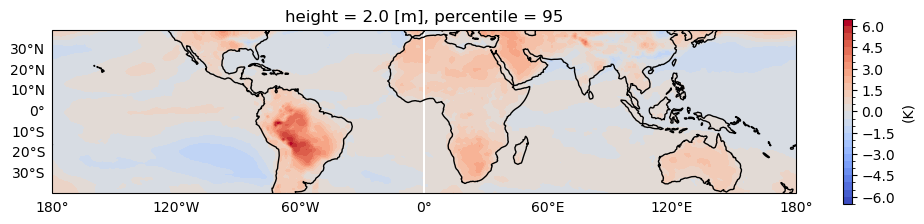

In [13]:
# Create a plot with Cartopy's PlateCarree projection
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data on the global map
# Plot filled contours with the 'coolwarm' colormap
contour = diffAnoms.plot.contourf(
    ax=ax, 
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
    add_colorbar=True, 
    cbar_kwargs={'label': '(K)', 'shrink': 0.4},
    levels = 30
)
# Add coastlines and borders
ax.coastlines()

# Optionally add gridlines
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.right_labels = False
gl.top_labels = False
gl.xlines = False  # Remove grid lines along x-axis
gl.ylines = False  # Remove grid lines along y-axis
# Show the plot
plt.show()

###### This is the projected warming of the 95th percentile of days discribed as the anomaly from the zonal mean warming

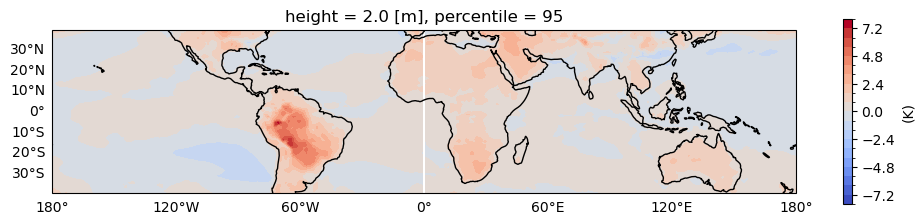

In [29]:
# Create a plot with Cartopy's PlateCarree projection
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data on the global map
# Plot filled contours with the 'coolwarm' colormap
contour = diffAnoms.plot.contourf(
    ax=ax, 
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
    add_colorbar=True, 
    cbar_kwargs={'label': '(K)', 'shrink': 0.4},
    levels = 24
)
# Add coastlines and borders
ax.coastlines()

# Optionally add gridlines
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.right_labels = False
gl.top_labels = False
gl.xlines = False  # Remove grid lines along x-axis
gl.ylines = False  # Remove grid lines along y-axis
# Show the plot
plt.show()

###### The difference between this one and the one above are subtle but this one discribes it as change averaged over the hottest 5% of days and not at what temperature the 95th percentile sits at

##### Functionalizing applying the percentiles 

In [32]:
def getMeansOverPercentile(ds, var, percentiles, avgOut = ['time']):
    ds[f'{var}_MOP'] = xr.apply_ufunc(
    lambda x: mean_above_percentiles(x, percentiles),
    ds[var],
    input_core_dims=[avgOut],
    output_core_dims=[["MOP"]],
    dask_gufunc_kwargs={
        'output_sizes': {"MOP": len(percentiles)},
        'allow_rechunk': True
    },
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float]
    )
    ds[f'{var}_MOP'] = ds[f'{var}_MOP'].assign_coords(MOP=percentiles)
    return ds

##### Functionalizing getting MOP but for a different variable that 

def mean_above_percentiles_difVar(data, dataCon, percentiles):
    import xarray as xr
    import numpy as np
    # Calculate the threshold for each percentile
    thresholds = np.nanpercentile(data, percentiles, axis=-1)
    means = np.full_like(percentiles, np.nan, dtype=np.float64)  # Pre-allocate array for means

    # Calculate mean for values above each threshold
    for i, threshold in enumerate(thresholds):
        above_threshold = data[data > threshold]
        if above_threshold.size > 0:
            means[i] = np.nanmean(above_threshold)
            
    return means
    
def getMeansOverPercentile_difVar(ds, var, conVar, percentiles, avgOut = ['time']):
    '''
        the virst specified variable is what it will use to find the percentile of and the second is the conVar which is the variable that we want the mean of 
    '''
    import xarray as xr
    import numpy as np
    import CMIPFuncs as func
    ds[f'{conVar}_MOP'] = xr.apply_ufunc(
    lambda x: func.mean_above_percentiles(x, ds[conVar], percentiles),
    ds[var],
    input_core_dims=[avgOut],
    output_core_dims=[["MOP"]],
    dask_gufunc_kwargs={
        'output_sizes': {"MOP": len(percentiles)},
        'allow_rechunk': True
    },
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float]
    )
    ds[f'{conVar}_MOP'] = ds[f'{conVar}_MOP'].assign_coords(MOP=percentiles)
    return ds



In [33]:
tas_ssp245 = xr.open_mfdataset(func.getVariable('tas', model, period)).tas
huss_ssp245 = xr.open_mfdataset(func.getVariable('huss', model, period)).huss
ds = xr.merge([tas_ssp245, huss_ssp245])
ds = func.regionTimeCut(ds, 'ssp245')
ds = getMeansOverPercentile_difVar(ds, 'tas', 'huss',np.arange(0,101,5))
ds

<xarray.Dataset> Size: 1GB
Dimensions:   (lat: 80, lon: 288, time: 7664, MOP: 21)
Coordinates:
    height    float64 8B 2.0
  * lat       (lat) float64 640B -39.5 -38.5 -37.5 -36.5 ... 36.5 37.5 38.5 39.5
  * lon       (lon) float64 2kB 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * time      (time) object 61kB 2080-01-01 12:00:00 ... 2100-12-30 12:00:00
  * MOP       (MOP) int64 168B 0 5 10 15 20 25 30 35 ... 70 75 80 85 90 95 100
Data variables:
    tas       (time, lat, lon) float32 706MB dask.array<chunksize=(1, 80, 288), meta=np.ndarray>
    huss      (time, lat, lon) float32 706MB dask.array<chunksize=(1, 80, 288), meta=np.ndarray>
    huss_MOP  (lat, lon, MOP) float64 4MB dask.array<chunksize=(80, 288, 21), meta=np.ndarray>
Attributes:
    long_name:      Near-Surface Air Temperature
    units:          K
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    standard_name:  air_temperature
    interp_method:  conserve_order2
    original_name:  tas